In [1]:
import torch 
import numpy as np
import os 
import sys
import os.path as osp

In [2]:
!ls data

2016_2018         data_era          tensor_completion y.npy


# 1- Load the data using the loader. Depending on the mode chosen, the iterator will output different dictionaries.

In [12]:

from dataclasses import dataclass, field, asdict
import imp

@dataclass
class Args:
    data_dir: str
    y_name: str
    vision_name: str
    predict_at: int
    window_size: int
    train_test_split: float
    mode: str
    batch_size: int
        
args = Args(data_dir="data/", 
            y_name="y.npy",
           vision_name="vision_data.npy", 
           predict_at=8,
           window_size=8, 
           train_test_split=0.8, 
           batch_size=10, 
           mode='intensity')

from src.prepro import create_loaders
train_loader, test_loader = create_loaders(**vars(args))

New dataset and corresponding sizes (null elements included):
X_vision torch.Size([3735, 8, 9, 25, 25])
X_stat torch.Size([3735, 8, 10])
target_displacement torch.Size([3735, 8, 2])
target_intensity torch.Size([3735])
target_intensity_cat torch.Size([3735])
target_intensity_cat_baseline torch.Size([3735])
Keeping 3143 samples out of the initial 3735.
Reshaping the displacement target...


**How does create_loaders work ?**
```python

vision_data = np.load(osp.join(data_dir, vision_name),
                          allow_pickle=True)
y = np.load(osp.join(data_dir, y_name),
                allow_pickle=True)

#Create named tensors
train_tensors, test_tensors = Prepro.process(
        y=y, 
        vision_data=vision_data,
        train_split=train_test_split,
        predict_at=predict_at,
        window_size=window_size)

#Filter the relevant keys
train_tensors, test_tensors = filter_keys(
     train_tensors, test_tensors, mode=mode)

#Unroll in tensordataset
train_ds = TensorDataset(*train_tensors.values())
test_ds = TensorDataset(*test_tensors.values())
    
#Create collate_fn 
collate_fn = create_collate_fn()


train_loader = DataLoader(train_ds, 
                            batch_size=batch_size, 
                            shuffle=True, 
                            drop_last=True,
                            collate_fn=collate_fn)

test_loader = DataLoader(test_ds, 
                            batch_size=batch_size, 
                            shuffle=False, 
                            collate_fn=collate_fn)
```

In [16]:
in_model, in_loss = next(iter(train_loader))
for k, v in in_model.items(): print('in_model', k, v.size())
for k, v in in_loss.items(): print('in_loss', k, v.size())

in_model x_viz torch.Size([10, 8, 9, 25, 25])
in_model x_stat torch.Size([10, 8, 10])
in_loss trg_y torch.Size([10])


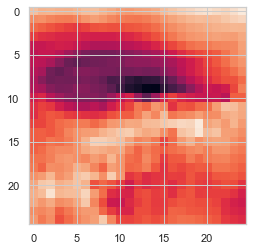

In [23]:
plt.imshow(in_model['x_viz'][0,0,1].detach().numpy());plt.show()

# 2 - Models
Experimental version in experimental_models (TO COME, see below).
___
The different configurations are stored in scripts/config.py.
We create a model as follows:

In [64]:
#if args.encdec: decoder_config = config.encdec_config
#elif args.transformer: decoder_config=config.transformer_config
#else: decoder_config = config.lineartransform_config
import sys
sys.path.append("../")
from scripts import config
from src.models import factory
from src import setup
#Just a hack for the notebook
args.encdec = True
args.transformer = False
args.output_dir = 'results/companion_notebook'
writer = setup.create_board(args)
device = setup.create_device(gpu_nb=-1)
args.device = None
args.writer = writer
# End of the hack

 Prepare the training using  cpu


In [67]:
encoder_config = config.encoder_config
decoder_config = config.encdec_config

model = models.factory.get_model(
        mode=args.mode, 
        encoder_config=encoder_config,
        decoder_config=decoder_config, 
        args=args)

model

ENCDEC(
  (encoder): CNNEncoder(
    (activation): ReLU()
    (layers): Sequential(
      (0): Conv2d(9, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1))
      (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU()
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): Flatten()
      (12): Linear(in_features=4096, out_features=256, bias=True)
      (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (14): ReLU()
      (15): Linear(in_features=2

**What are the refistered models?**

In [68]:
print(models.factory.MODEL_REGISTRY)

{'CNNEncoder': <class 'src.models.hurricast_models.CNNEncoder'>, 'ENCDEC': <class 'src.models.hurricast_models.ENCDEC'>, 'TRANSFORMER': <class 'src.models.hurricast_models.TRANSFORMER'>, 'LINEARTransform': <class 'src.models.hurricast_models.LINEARTransform'>}


**The model creation is wrapped using the models/factory.py file and the function:**
```py
def get_model(mode, encoder_config, decoder_config, args):
    #Needs to upload window size and _OUT_DECODER
    #Get some
    assert (int(args.encdec) + int(args.transformer) < 2), "\
    Only one of encdec or transformer can be specified"

    _encoder = MODEL_REGISTRY['CNNEncoder']
    if args.encdec:
        _model = MODEL_REGISTRY['ENCDEC']
    elif args.transformer:
        _model = MODEL_REGISTRY['TRANSFORMER']
    else:
        model = MODEL_REGISTRY['LINEARTransform']

    N_OUT_DECODER = 7 if mode == 'intensity_cat' else (
        2 - (mode == 'intensity'))  # 7 classes of storms if categorical

    #Encoder
    encoder_config = encoder_config if isinstance(encoder_config, dict)\
        else vars(encoder_config)

    encoder = _encoder(**encoder_config)

    #Decoder: Update the config
    decoder_config = decoder_config if isinstance(decoder_config, dict)\
        else vars(encoder_config)

    if not args.encdec and not args.transformer:
        decoder_config['target_intensity'] = args.target_intensity,
        decoder_config['target_intensity_cat'] = args.target_intensity_cat

    else:
        decoder_config['encoder'] = encoder
        decoder_config['window_size'] = args.window_size
        decoder_config['n_out_decoder'] = N_OUT_DECODER

    model = _model(**decoder_config)

    model = model.to(args.device)

    if args.writer is not None:
        configs = [encoder_config, decoder_config]
        config_ = ""
        for config__ in configs:
            config_ += "{}\n".format(config__)
        args.writer.add_text('Configs', config_)
    return model
```


# 3  - Prepare the training

In [69]:
optimizer = torch.optim.Adam(
        model.parameters(),
        lr=1e-4)

In [75]:
#Hack for the notebook
from src import metrics, run
args.n_epochs = 1
args.get_training_stats = True
task = 'regression'
train_loss_fn, \
eval_loss_fn, metrics_fn = metrics.create_metrics_fn(task)

best_model, \
        optimizer, \
        training_stats = run.train(
            model, optimizer,
            num_epochs=args.n_epochs,
            train_loss_fn=train_loss_fn,
            test_loss_fn=eval_loss_fn,
            metrics_fn=metrics_fn,
            train_iterator=train_loader,
            val_iterator=test_loader,
            test_iterator=test_loader,
            mode=args.mode,
            task=task,
            get_training_stats=args.get_training_stats,
            clip=None,
            scheduler=None,
            l2_reg=0.,
            save=False,
            args=args,
            output_dir=args.output_dir,
            writer=args.writer)



Epochs:   0%|          | 0/1 [00:00<?, ?it/s]


Inner Training loop:   0%|          | 0/251 [00:00<?, ?it/s]/Users/theoguenais/anaconda/envs/graphcnn/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Inner Training loop:   0%|          | 1/251 [00:00<03:55,  1.06it/s]


Inner Training loop:   1%|          | 2/251 [00:01<03:54,  1.06it/s]


Inner Training loop:   1%|          | 3/251 [00:02<03:37,  1.14it/s]


Inner Training loop:   2%|▏         | 4/251 [00:03<03:32,  1.16it/s]


Inner Training loop:   2%|▏         | 5/251 [00:04<03:24,  1.20it/s]


Inner Training loop:   2%|▏         | 6/251 [00:05<03:23,  1.20it/s]


Inner Training loop:   3%|▎         | 7/251 [00:05<03:32,  1.15it/s]


Inner Training 

Inner Training loop:  38%|███▊      | 96/251 [01:12<02:01,  1.27it/s]


Inner Training loop:  39%|███▊      | 97/251 [01:13<02:00,  1.28it/s]


Inner Training loop:  39%|███▉      | 98/251 [01:14<02:01,  1.26it/s]


Inner Training loop:  39%|███▉      | 99/251 [01:15<02:01,  1.25it/s]


Inner Training loop:  40%|███▉      | 100/251 [01:16<02:10,  1.16it/s]


Inner Training loop:  40%|████      | 101/251 [01:16<02:09,  1.16it/s]


Inner Training loop:  41%|████      | 102/251 [01:17<02:10,  1.14it/s]


Inner Training loop:  41%|████      | 103/251 [01:18<02:12,  1.12it/s]


Inner Training loop:  41%|████▏     | 104/251 [01:19<02:10,  1.13it/s]


Inner Training loop:  42%|████▏     | 105/251 [01:20<02:00,  1.21it/s]


Inner Training loop:  42%|████▏     | 106/251 [01:21<02:02,  1.19it/s]


Inner Training loop:  43%|████▎     | 107/251 [01:21<01:53,  1.27it/s]


Inner Training loop:  43%|████▎     | 108/251 [01:22<01:57,  1.22it/s]


Inner Training loop:  43%|████▎     | 109/251 [01:23<01

Inner Training loop:  78%|███████▊  | 195/251 [02:53<00:48,  1.15it/s]


Inner Training loop:  78%|███████▊  | 196/251 [02:54<00:47,  1.16it/s]


Inner Training loop:  78%|███████▊  | 197/251 [02:54<00:47,  1.14it/s]


Inner Training loop:  79%|███████▉  | 198/251 [02:55<00:46,  1.15it/s]


Inner Training loop:  79%|███████▉  | 199/251 [02:56<00:41,  1.25it/s]


Inner Training loop:  80%|███████▉  | 200/251 [02:57<00:40,  1.27it/s]


Inner Training loop:  80%|████████  | 201/251 [02:58<00:40,  1.24it/s]


Inner Training loop:  80%|████████  | 202/251 [02:58<00:40,  1.21it/s]


Inner Training loop:  81%|████████  | 203/251 [02:59<00:40,  1.19it/s]


Inner Training loop:  81%|████████▏ | 204/251 [03:01<00:44,  1.05it/s]


Inner Training loop:  82%|████████▏ | 205/251 [03:01<00:42,  1.08it/s]


Inner Training loop:  82%|████████▏ | 206/251 [03:02<00:42,  1.06it/s]


Inner Training loop:  82%|████████▏ | 207/251 [03:04<00:44,  1.02s/it]


Inner Training loop:  83%|████████▎ | 208/251 [03:0

TypeError: forward() got an unexpected keyword argument 'x'

### How does the training work exactly?
1. **We Backprop and train for one epoch**
```py
train_losses, \
preds, true_preds = train_epoch(
                        model=model,
                        train_iterator=train_iterator,
                        optimizer=optimizer,
                        loss_fn=train_loss_fn,
                        global_step=epoch,
                        task=get_training_stats,
                        return_pt=True,
                        l2_reg=l2_reg,
                        clip=clip,
                        scheduler=scheduler)
```
2. **Obtain the training metrics.**
```py
train_metrics = metrics_fn(preds, true_preds)
```   
3. **Eval (metrics obtained in the function directly).**
```py
preds, true_preds, \
valid_loss, eval_metrics = evaluate(
                                    model=model, 
                                    iterator=val_iterator,
                                    loss_fn=test_loss_fn,
                                    metrics_func=metrics_fn,
                                    task=task)
```

**We repeat the above for each epoch.**

The final output of the training is: 
```py
best_model, optimizer, training_stats : dict = {
                                'train_metrics': ...,
                                'eval_metrics': ...,
                                'test_metrics': ...,
                                'test_preds': ...,
                                'test_labels': ...
                                }
```                               